<a href="https://colab.research.google.com/github/Prajjwal-001-py/Medical-Disease-Image-Detection-Model/blob/main/Medical_image_classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
     from google.colab import files
files.upload() # Upload your kaggle.json here

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -q chest-xray-pneumonia.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 98% 2.24G/2.29G [00:16<00:01, 41.2MB/s]
100% 2.29G/2.29G [00:16<00:00, 149MB/s] 


In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [3]:
# Define paths based on the unzipped folder structure
train_dir = 'chest_xray/train'
val_dir = 'chest_xray/val'
test_dir = 'chest_xray/test'

# Hyperparameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Augmentation strategy
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary')

val_gen = test_val_datagen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary')

test_gen = test_val_datagen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary', shuffle=False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [4]:
def build_medical_model():
    # Load DenseNet121 with ImageNet weights, exclude top layer
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False # Freeze backbone for initial training

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x) # High dropout to fight overfitting
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model

model = build_medical_model()
model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,304,257 (27.86 MB)

 Trainable params: 264,705 (1.01 MB)

 Non-trainable params: 7,039,552 (26.85 MB)

In [5]:
# Callbacks for optimization
callbacks = [
    ModelCheckpoint('best_pneumonia_model.h5', save_best_only=True, monitor='val_loss'),
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
]

# Balance classes (Pneumonia images usually outnumber Normal ones)
# This improves "Recall," which is critical in medicine (minimizing False Negatives)
history = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 618ms/step - accuracy: 0.7766 - loss: 0.4409 - precision: 0.8972 - recall: 0.7831

163/163 ━━━━━━━━━━━━━━━━━━━━ 147s 725ms/step - accuracy: 0.7770 - loss: 0.4402 - precision: 0.8974 - recall: 0.7836 - val_accuracy: 0.8750 - val_loss: 0.4194 - val_precision: 0.8000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 628ms/step - accuracy: 0.9133 - loss: 0.2046 - precision: 0.9482 - recall: 0.9359 - val_accuracy: 0.7500 - val_loss: 0.4521 - val_precision: 0.6667 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 614ms/step - accuracy: 0.9316 - loss: 0.1729 - precision: 0.9572 - recall: 0.9503 - val_accuracy: 0.7500 - val_loss: 0.4450 - val_precision: 0.6667 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.9398 - loss: 0.1621 - precision: 0.9608 - recall: 0.9582

163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 616ms/step - accuracy: 0.9398 - loss: 0.1621 - precision: 0.9608 - recall: 0.9582 - val_accuracy: 0.8125 - val_loss: 0.4127 - val_precision: 0.7273 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.9383 - loss: 0.1495 - precision: 0.9583 - recall: 0.9583

163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 616ms/step - accuracy: 0.9384 - loss: 0.1495 - precision: 0.9583 - recall: 0.9583 - val_accuracy: 0.7500 - val_loss: 0.3393 - val_precision: 0.7000 - val_recall: 0.8750 - learning_rate: 1.0000e-04
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.9476 - loss: 0.1305 - precision: 0.9672 - recall: 0.9618

163/163 ━━━━━━━━━━━━━━━━━━━━ 142s 619ms/step - accuracy: 0.9476 - loss: 0.1305 - precision: 0.9672 - recall: 0.9618 - val_accuracy: 0.8125 - val_loss: 0.3174 - val_precision: 0.7778 - val_recall: 0.8750 - learning_rate: 1.0000e-04
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 607ms/step - accuracy: 0.9385 - loss: 0.1540 - precision: 0.9552 - recall: 0.9626 - val_accuracy: 0.8750 - val_loss: 0.3951 - val_precision: 0.8000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 612ms/step - accuracy: 0.9557 - loss: 0.1218 - precision: 0.9691 - recall: 0.9707 - val_accuracy: 0.8750 - val_loss: 0.3485 - val_precision: 0.8000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 9/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 615ms/step - accuracy: 0.9524 - loss: 0.1204 - precision: 0.9679 - recall: 0.9689 - val_accuracy: 0.8750 - val_loss: 0.3827 - val_precision: 0.8000 - val_recall: 1.0000 - learning_rate: 1.0000e-04


20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 804ms/step


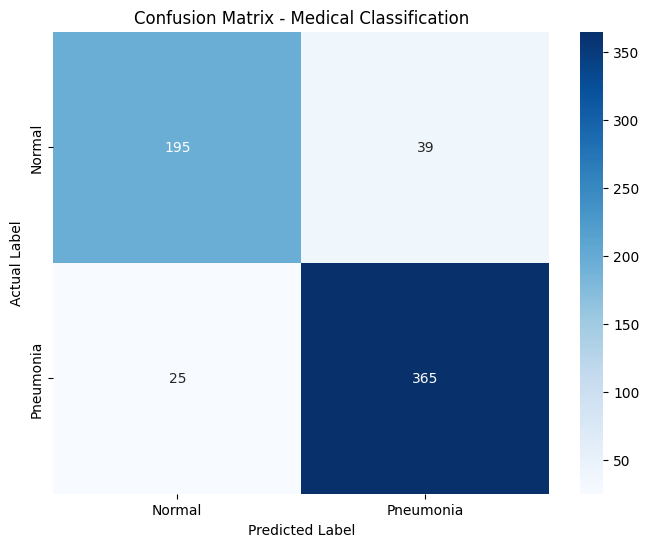

              precision    recall  f1-score   support

      Normal       0.89      0.83      0.86       234
   Pneumonia       0.90      0.94      0.92       390

    accuracy                           0.90       624
   macro avg       0.89      0.88      0.89       624
weighted avg       0.90      0.90      0.90       624



In [7]:
# Load the best weights saved during training
model.load_weights('best_pneumonia_model.h5')

# Predict on test data
predictions = model.predict(test_gen)
y_pred = (predictions > 0.5).astype(int)
y_true = test_gen.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.title('Confusion Matrix - Medical Classification')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Final Metrics Report
print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))